<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [1]:
# import needed stuff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Load the data.
df = pd.read_csv('amesHousePrice.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# dropping the ID column
df = df.drop('Id', axis=1)
df = df.drop('Alley', axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# checking null values
df.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
GarageYrBlt        81
BsmtExposure       38
BsmtFinType2       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
RoofStyle           0
RoofMatl            0
ExterQual           0
Exterior1st         0
Exterior2nd         0
YearBuilt           0
ExterCond           0
Foundation          0
YearRemodAdd        0
SalePrice           0
OverallCond         0
OverallQual         0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [5]:
# will replace NaN values depending on column type.
# if numeric, will replace with 0. Since they're home prices, we'll probably want to replace with mean or median.
# but we'll do that before we do any major manipulations
# if categorical, will replace with "Unknown"

df_2 = df.copy()

for column in df_2.columns:
    if df_2[column].dtype=='O':
        df_2[column] = df_2[column].fillna(value='Unknown')
    else:
        df_2[column] = df_2[column].fillna(value=0)

# checking
df_2.isnull().sum().sort_values(ascending=False)

SalePrice       0
BsmtQual        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
Foundation      0
BsmtCond        0
RoofStyle       0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
RoofMatl        0
YearRemodAdd    0
HeatingQC       0
LotConfig       0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
LotShape        0
LandContour     0
Utilities       0
LandSlope       0
               ..
PoolArea        0
GarageCars      0
PoolQC          0
Fence           0
MiscFeature     0
MiscVal         0
MoSold          0
YrSold          0
SaleType        0
GarageArea      0
GarageFinish    0
Electrical      0
HalfBath        0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
GrLivArea       0
BsmtFullBath    0
BsmtHalfBath    0
FullBath        0
BedroomAbvGr    0
GarageYrBlt     0
KitchenAbvGr    0
KitchenQual     0
TotRmsAbvG

In [6]:
train, test = train_test_split(df_2)

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
412,20,FV,0.0,4403,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,0,Unknown,Unknown,Unknown,0,6,2010,New,Partial,222000
871,60,RL,70.0,8750,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,Unknown,Unknown,Unknown,0,6,2010,WD,Normal,200500
791,80,RL,0.0,11333,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,Unknown,Unknown,Unknown,0,5,2007,WD,Normal,146800
1026,20,RL,73.0,9300,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,Unknown,Unknown,Unknown,0,4,2010,WD,Normal,167500
908,20,RL,0.0,8885,Pave,IR1,Low,AllPub,Inside,Mod,...,0,Unknown,MnPrv,Unknown,0,6,2006,WD,Normal,131000


In [7]:
# making X and y sets

# training data set
y_train = train['SalePrice']
X_train = train.drop('SalePrice', axis=1)

# test data set
y_test = test['SalePrice']
X_test = test.drop('SalePrice', axis=1)

X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
412,20,FV,0.0,4403,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,0,0,Unknown,Unknown,Unknown,0,6,2010,New,Partial
871,60,RL,70.0,8750,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,Unknown,Unknown,Unknown,0,6,2010,WD,Normal
791,80,RL,0.0,11333,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,Unknown,Unknown,Unknown,0,5,2007,WD,Normal
1026,20,RL,73.0,9300,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,143,0,Unknown,Unknown,Unknown,0,4,2010,WD,Normal
908,20,RL,0.0,8885,Pave,IR1,Low,AllPub,Inside,Mod,...,0,0,Unknown,MnPrv,Unknown,0,6,2006,WD,Normal


In [8]:
# between one-hot encoding and ordinal encoding, ordinal encoding will probably give us a better output
# It'll also give us a chance to change all the numeric 0 values to something more helpful (the mean)
# We'll do the ordinal encoding, then normalize (squishify) the data

# instantiating classes
encoder = OrdinalEncoder()
normalizer = Normalizer()

# encoding then normalizing data
X_train_encoded = encoder.fit_transform(X_train)
X_train_normalized = normalizer.fit_transform(X_train_encoded)

X_test_encoded = encoder.fit_transform(X_test)
X_test_normalized = normalizer.fit_transform(X_test_encoded)

In [9]:
# for this model, tried including all dense layers as without the .add method
model = Sequential([
    Dense(10, input_dim=78, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='relu')
])
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mean_squared_error'])

# checking summary
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                790       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


In [10]:
fitted = model.fit(X_train_normalized, y_train, epochs=100)

Epoch 1/100
1095/1095 [==============================] - 0s 385us/sample - loss: 39796761062.2831 - mean_squared_error: 39796760576.0000
Epoch 2/100
1095/1095 [==============================] - 0s 97us/sample - loss: 39796589748.4858 - mean_squared_error: 39796588544.0000
Epoch 3/100
1095/1095 [==============================] - 0s 91us/sample - loss: 39795932503.2037 - mean_squared_error: 39795937280.0000
Epoch 4/100
1095/1095 [==============================] - 0s 95us/sample - loss: 39794015044.0329 - mean_squared_error: 39794020352.0000
Epoch 5/100
1095/1095 [==============================] - 0s 91us/sample - loss: 39790075748.7635 - mean_squared_error: 39790075904.0000
Epoch 6/100
1095/1095 [==============================] - 0s 91us/sample - loss: 39781899696.9790 - mean_squared_error: 39781900288.0000
Epoch 7/100
1095/1095 [==============================] - 0s 104us/sample - loss: 39766850873.2785 - mean_squared_error: 39766855680.0000
Epoch 8/100
1095/1095 [=======================

1095/1095 [==============================] - 0s 151us/sample - loss: 5897686961.4466 - mean_squared_error: 5897687040.0000
Epoch 61/100
1095/1095 [==============================] - 0s 154us/sample - loss: 5876375778.5425 - mean_squared_error: 5876375552.0000
Epoch 62/100
1095/1095 [==============================] - 0s 169us/sample - loss: 5861267951.8685 - mean_squared_error: 5861267968.0000
Epoch 63/100
1095/1095 [==============================] - 0s 171us/sample - loss: 5847218322.9370 - mean_squared_error: 5847217664.0000
Epoch 64/100
1095/1095 [==============================] - 0s 175us/sample - loss: 5833792364.2447 - mean_squared_error: 5833792512.0000
Epoch 65/100
1095/1095 [==============================] - 0s 166us/sample - loss: 5822547539.1123 - mean_squared_error: 5822546944.0000
Epoch 66/100
1095/1095 [==============================] - 0s 168us/sample - loss: 5809005342.6265 - mean_squared_error: 5809005056.0000
Epoch 67/100
1095/1095 [==============================] - 0s 

In [11]:
scores = model.evaluate(X_test_normalized, y_test)

365/365 [==============================] - 1s 2ms/sample - loss: 4890288847.6055 - mean_squared_error: 4890288640.0000


In [12]:
# visualizing loss of pyplot
import matplotlib.pyplot as plt
plt.plot(fitted.history['loss'])
plt.title('Neural network training epochs')
plt.xlabel('Epoch #')
plt.ylabel('Mean Squared Error (Billion)')
plt.show()

<Figure size 640x480 with 1 Axes>

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [13]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

In [14]:
# making training and test data from the mnist data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [15]:
np.unique(y_train, return_counts=True)
# using the above query, we can see that there are ten total classes (possible outputs) in the data

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [16]:
num_classes = 10

In [17]:
#need to reshape the vectors into 1 dimensional arrays from 28x28 dimensional images
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# Change dtypes to force floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# encode target to a categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [20]:
mnist_nn = Sequential()

mnist_nn.add(Dense(100, activation='relu', input_dim=784))
mnist_nn.add(Dense(100, activation='relu'))
# softmax was helpful for strictly multi-class classification
mnist_nn.add(Dense(10, activation='softmax'))

mnist_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mnist_nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [22]:
# took forever to run without batching
mnist_run = mnist_nn.fit(x_train, y_train, epochs=100, validation_split=.10,batch_size=300)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 5s 97us/sample - loss: 0.4593 - acc: 0.8444 - val_loss: 0.5822 - val_acc: 0.8302
Epoch 2/100
54000/54000 [==============================] - 5s 94us/sample - loss: 0.4257 - acc: 0.8513 - val_loss: 0.5745 - val_acc: 0.8325
Epoch 3/100
54000/54000 [==============================] - 5s 94us/sample - loss: 0.4151 - acc: 0.8554 - val_loss: 0.5562 - val_acc: 0.8368
Epoch 4/100
54000/54000 [==============================] - 5s 97us/sample - loss: 0.4036 - acc: 0.8575 - val_loss: 0.5229 - val_acc: 0.8402
Epoch 5/100
54000/54000 [==============================] - 7s 122us/sample - loss: 0.3824 - acc: 0.8628 - val_loss: 0.5097 - val_acc: 0.8428
Epoch 6/100
54000/54000 [==============================] - 7s 129us/sample - loss: 0.3667 - acc: 0.8665 - val_loss: 0.4933 - val_acc: 0.8507
Epoch 7/100
54000/54000 [==============================] - 6s 117us/sample - loss: 0.3580 - acc: 0.8710 - val

Epoch 59/100
54000/54000 [==============================] - 1s 16us/sample - loss: 0.2213 - acc: 0.9174 - val_loss: 0.4979 - val_acc: 0.8660
Epoch 60/100
54000/54000 [==============================] - 1s 15us/sample - loss: 0.2212 - acc: 0.9169 - val_loss: 0.4943 - val_acc: 0.8710
Epoch 61/100
54000/54000 [==============================] - 1s 18us/sample - loss: 0.2343 - acc: 0.9125 - val_loss: 0.5353 - val_acc: 0.8647
Epoch 62/100
54000/54000 [==============================] - 1s 20us/sample - loss: 0.2242 - acc: 0.9160 - val_loss: 0.5198 - val_acc: 0.8700
Epoch 63/100
54000/54000 [==============================] - 1s 19us/sample - loss: 0.2246 - acc: 0.9175 - val_loss: 0.4831 - val_acc: 0.8698
Epoch 64/100
54000/54000 [==============================] - 1s 20us/sample - loss: 0.2246 - acc: 0.9155 - val_loss: 0.5120 - val_acc: 0.8670
Epoch 65/100
54000/54000 [==============================] - 1s 20us/sample - loss: 0.2255 - acc: 0.9157 - val_loss: 0.4955 - val_acc: 0.8743
Epoch 66/100


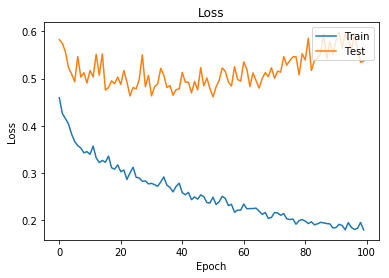

In [23]:
# Plot training & validation loss values
plt.plot(mnist_run.history['loss'])
plt.plot(mnist_run.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [24]:
scores = mnist_nn.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 445us/sample - loss: 0.5564 - acc: 0.8707


In [25]:
# accuracy of only 10%?
# edit: tweaked the model and got accuracy of 87%!
print("Accuacy:",scores[1]*100)

Accuacy: 87.07000017166138


## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.